In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
INPUT_DIR_A = "/content/drive/MyDrive/Colab Notebooks/Heartbeat"
INPUT_DIR_A_WAVE = "/content/drive/MyDrive/Colab Notebooks/Heartbeat/set_a"
INPUT_DIR_B_WAVE = "/content/drive/MyDrive/Colab Notebooks/Heartbeat/set_b"

# **CNN+LSTM**

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Step 4: Loading and cleaning the dataset...
Dataset loaded. Shape: (176, 4)
Label distribution:
label
NaN         52
artifact    40
murmur      34
normal      31
extrahls    19
Name: count, dtype: int64
After filtering missing labels and invalid paths: 124 samples
Found 4 classes: ['artifact', 'extrahls', 'murmur', 'normal']

Step 5: Processing audio files...
Feature extraction complete. Total samples: 496
Training set: (396, 128, 128, 1), Test set: (100, 128, 128, 1)

Step 6: Training models for different epoch values...

--- Training Model with 100 Epochs ---
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 331ms/step - accuracy: 0.4580 - loss: 1.7630 - val_accuracy: 0.3000 - val_loss: 3.9257
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5731 - loss: 1.0324 - val_accuracy: 0.3600 - val_loss: 1.8212
Epoch 3/100
25/25 ━

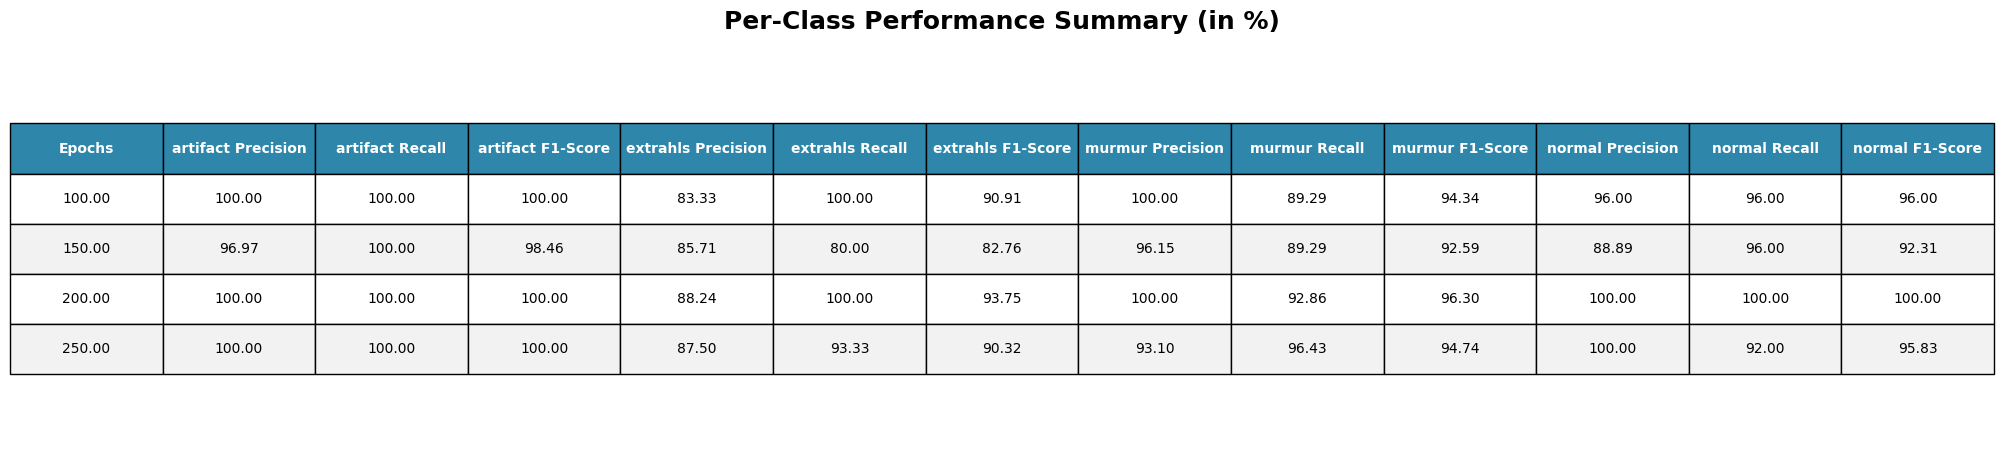


--- Generating Accuracy and Loss Curves ---


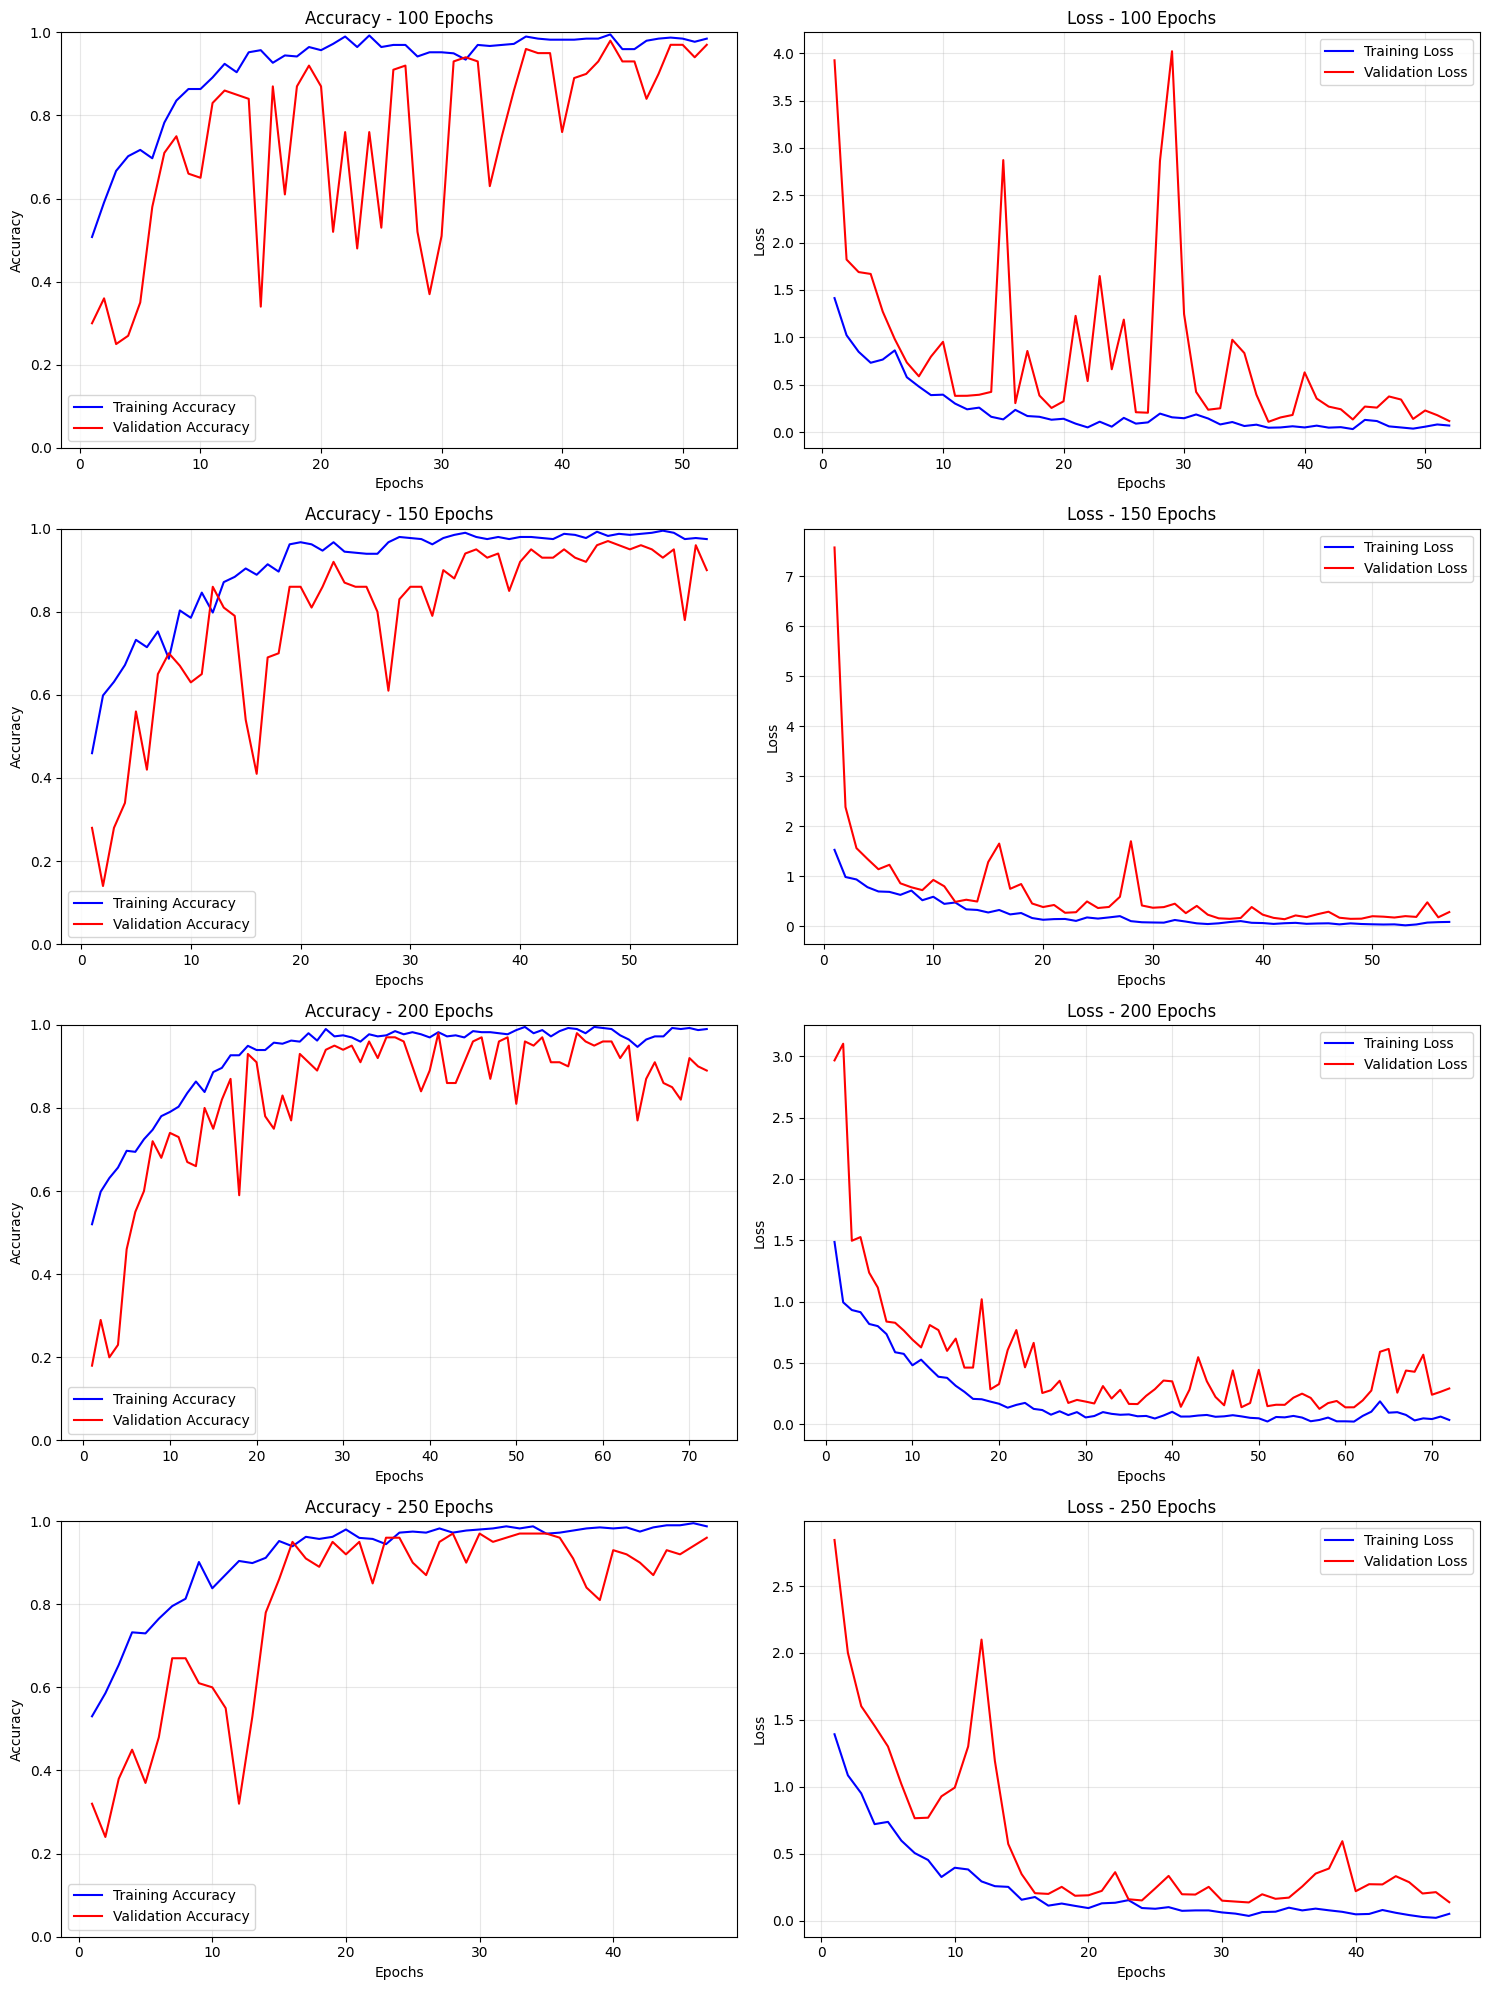


--- Generating Confusion Matrices ---


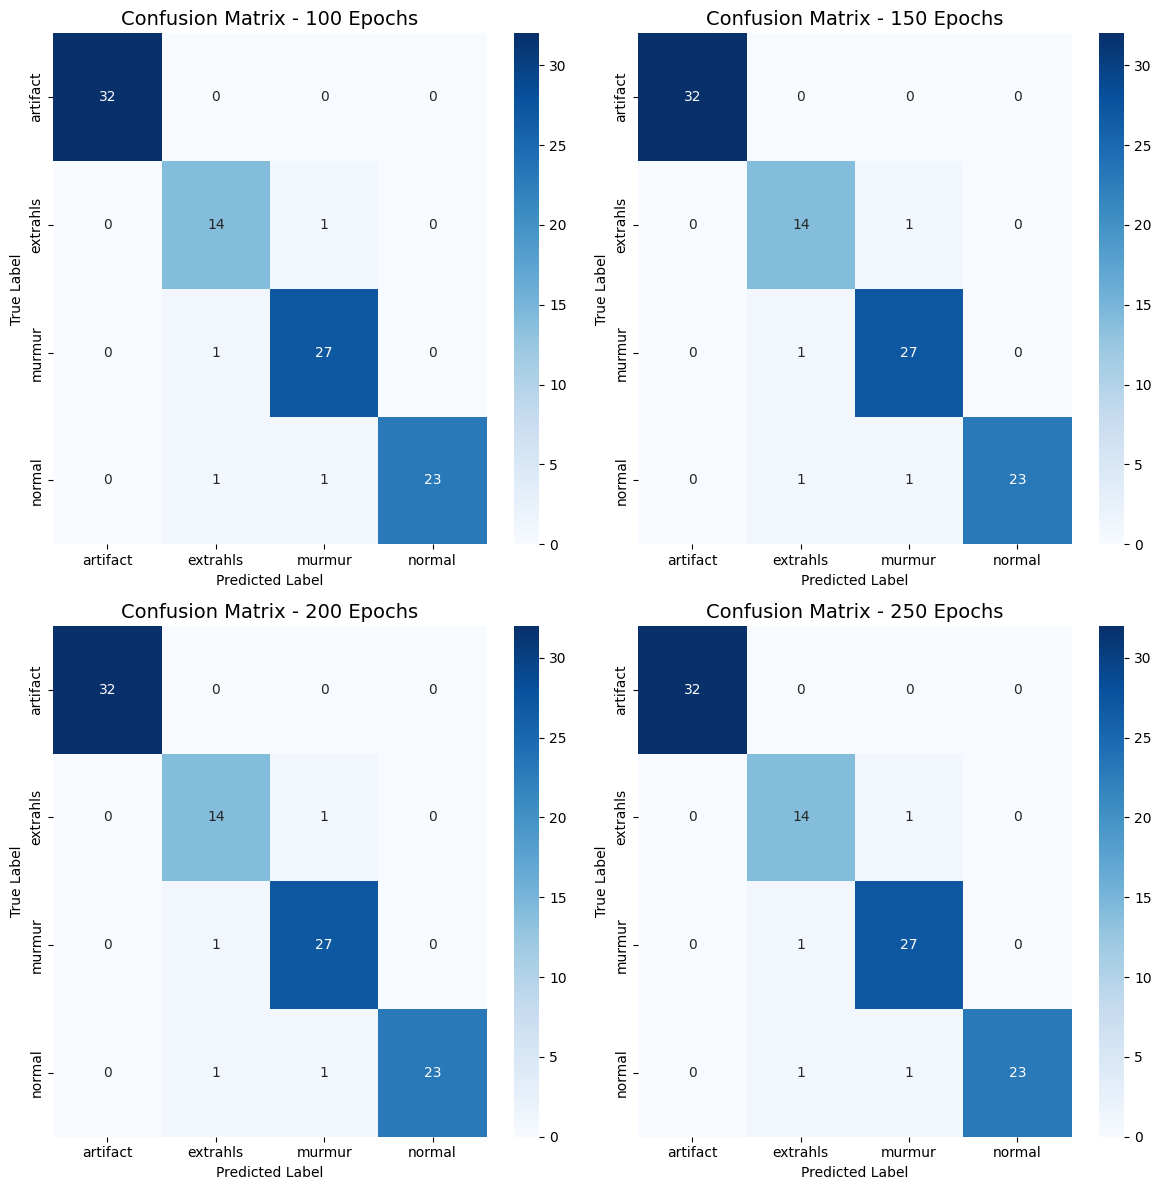

In [ ]:
# Step 1: Install and Import Libraries
# !pip install librosa soundfile scikit-learn tensorflow seaborn
import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 2: Mount Google Drive ---
print("Mounting Google Drive...")
drive.mount('/content/drive')

# --- Step 3: Define Paths ---
INPUT_DIR_A_CSV = "/content/drive/MyDrive/Colab Notebooks/Heartbeat/set_a.csv"
INPUT_DIR_A_WAVE = "/content/drive/MyDrive/Colab Notebooks/Heartbeat/set_a"

# --- Step 4: Load and Clean the Dataset ---
print("\nStep 4: Loading and cleaning the dataset...")
try:
    df_a = pd.read_csv(INPUT_DIR_A_CSV)
    print(f"Dataset loaded. Shape: {df_a.shape}")
    print(f"Label distribution:\n{df_a['label'].value_counts(dropna=False)}")

    # CRITICAL: Filter out rows with missing labels
    df_a_filtered = df_a.dropna(subset=['label'])
    # Also filter out rows with empty or invalid file paths
    df_a_filtered = df_a_filtered[df_a_filtered['fname'].str.strip() != '']
    print(f"After filtering missing labels and invalid paths: {df_a_filtered.shape[0]} samples")
except Exception as e:
    print(f"Error: {e}")
    df_a_filtered = pd.DataFrame()

# --- Step 5: Preprocessing and Feature Extraction ---
if not df_a_filtered.empty:
    # Create label mapping
    unique_labels = sorted(df_a_filtered['label'].unique())
    label_to_int = {label: i for i, label in enumerate(unique_labels)}
    num_classes = len(unique_labels)
    print(f"Found {num_classes} classes: {unique_labels}")

    # Parameters
    target_width = 128
    SAMPLE_RATE = 22050

    def augment_audio(audio, sample_rate, aug_type):
        if aug_type == 'time_stretch':
            rate = random.uniform(0.9, 1.1)
            return librosa.effects.time_stretch(y=audio, rate=rate)
        elif aug_type == 'pitch_shift':
            n_steps = random.randint(-1, 1)
            return librosa.effects.pitch_shift(y=audio, sr=sample_rate, n_steps=n_steps)
        elif aug_type == 'add_noise':
            noise_level = random.uniform(0.001, 0.003)
            noise = np.random.randn(len(audio)) * noise_level
            return audio + noise
        else:
            return audio

    X = []
    y = []

    print("\nStep 5: Processing audio files...")
    for _, row in df_a_filtered.iterrows():
        file_name = row['fname']
        label = row['label']

        # Fix the file path
        if file_name.startswith('set_a/'):
            relative_file_name = file_name[len('set_a/'):]
        else:
            relative_file_name = file_name
        audio_path = os.path.join(INPUT_DIR_A_WAVE, relative_file_name)

        try:
            audio, sample_rate = sf.read(audio_path)
            if len(audio.shape) > 1:
                audio = np.mean(audio, axis=1)
            if sample_rate != SAMPLE_RATE:
                audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=SAMPLE_RATE)

            # Apply augmentations
            for aug_type in [None, 'time_stretch', 'pitch_shift', 'add_noise']:
                aug_audio = augment_audio(audio, SAMPLE_RATE, aug_type)

                # Extract Mel-Spectrogram
                mel = librosa.feature.melspectrogram(y=aug_audio, sr=SAMPLE_RATE, n_mels=128, fmax=8000)
                log_mel = librosa.power_to_db(mel, ref=np.max)

                # Pad or truncate
                if log_mel.shape[1] < target_width:
                    log_mel = np.pad(log_mel, ((0,0), (0, target_width-log_mel.shape[1])), mode='constant')
                else:
                    log_mel = log_mel[:, :target_width]

                log_mel = np.expand_dims(log_mel, -1)
                X.append(log_mel)
                y.append(label_to_int[label])

        except Exception as e:
            print(f"Skipped {file_name}: {e}")

    X = np.array(X)
    y = np.array(y)
    print(f"Feature extraction complete. Total samples: {len(X)}")

    # Split the data
    if len(X) > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
    else:
        print("No valid data to split.")
        X_train, X_test, y_train, y_test = None, None, None, None
else:
    print("No valid data to process.")
    X_train, X_test, y_train, y_test = None, None, None, None

# --- Step 6: Define Model Architecture and Train for Different Epochs ---
if X_train is not None:
    # Fixed batch size
    BATCH_SIZE = 16
    EPOCHS_LIST = [100, 150, 200, 250]

    # Dictionary to store results
    results = []

    print("\nStep 6: Training models for different epoch values...")

    # Define the model architecture once, but create a new instance for each training run
    def create_model():
        model = Sequential([
            Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
            Conv2D(32, (3,3), activation='relu'), BatchNormalization(), Dropout(0.2),
            Conv2D(32, (3,3), activation='relu'), MaxPooling2D((2,2)),
            Conv2D(64, (3,3), activation='relu'), BatchNormalization(), Dropout(0.3),
            Conv2D(64, (3,3), activation='relu'), MaxPooling2D((2,2)),
            Conv2D(128, (3,3), activation='relu'), BatchNormalization(), Dropout(0.4),
            Conv2D(128, (3,3), activation='relu'), MaxPooling2D((2,2)),
            Flatten(),
            Dense(512, activation='relu'), BatchNormalization(), Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    # Train and evaluate for each epoch value
    for epochs in EPOCHS_LIST:
        print(f"\n--- Training Model with {epochs} Epochs ---")

        # Create a fresh model instance for each run
        model = create_model()

        # Use Early Stopping to prevent overfitting
        early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

        # Train the model
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=BATCH_SIZE,
            validation_data=(X_test, y_test),
            callbacks=[early_stop],
            verbose=1
        )

        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        precision = precision_score(y_test, y_pred_classes, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred_classes, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred_classes, average='weighted', zero_division=0)

        # --- Calculate the detailed classification report ---
        class_report = classification_report(y_test, y_pred_classes, target_names=unique_labels,
                                             output_dict=True, zero_division=0)

        # Store results
        result = {
            'Epochs': epochs,
            'Accuracy': test_accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'History': history,
            'Classification_Report': class_report
        }
        results.append(result)

        # Print results for this run
        print(f"Results for {epochs} epochs:")
        print(f"  Test Accuracy: {test_accuracy*100:.2f}%")
        print(f"  Precision: {precision*100:.2f}%")
        print(f"  Recall: {recall*100:.2f}%")
        print(f"  F1-Score: {f1*100:.2f}%")

    # --- Step 7: Final Summary and Plotting ---
    print("\n=== FINAL SUMMARY ===")
    for result in results:
        print(f"Epochs: {result['Epochs']:3d} | "
              f"Accuracy: {result['Accuracy']*100:6.2f}% | "
              f"Precision: {result['Precision']*100:6.2f}% | "
              f"Recall: {result['Recall']*100:6.2f}% | "
              f"F1-Score: {result['F1-Score']*100:6.2f}%")

    # --- Visualization Block ---

    # --- 1. Create a Detailed Classification Report Table (Graphical Box) ---
    print("\n--- Generating Classification Report Table ---")

    # Prepare data for the table
    summary_data = []
    for result in results:
        row = {'Epochs': result['Epochs']}
        class_report = result['Classification_Report']
        for label in unique_labels:
            # Truncate the label name to avoid long column headers
            short_label = label[:15]  # Limit to first 10 characters
            if label in class_report:
                row[f'{short_label} Precision'] = class_report[label]['precision'] * 100
                row[f'{short_label} Recall'] = class_report[label]['recall'] * 100
                row[f'{short_label} F1-Score'] = class_report[label]['f1-score'] * 100
            else:
                row[f'{short_label} Precision'] = 0.0
                row[f'{short_label} Recall'] = 0.0
                row[f'{short_label} F1-Score'] = 0.0
        summary_data.append(row)

    # Define column labels with truncated names and spaces
    col_labels = ['Epochs'] + [f'{label[:15]} {metric}' for label in unique_labels for metric in ['Precision', 'Recall', 'F1-Score']]
    # Format the data for the table
    cell_data = [[f"{item:.2f}" for item in row.values()] for row in summary_data]

    # Create a figure for the summary table
    fig, ax = plt.subplots(figsize=(16, len(summary_data) * 1.0 + 1))
    ax.axis('tight')
    ax.axis('off')
    ax.set_title('Per-Class Performance Summary (in %)', fontsize=18, pad=20, fontweight='bold')

    # Create the table
    table = ax.table(cellText=cell_data,
                    colLabels=col_labels,
                    cellLoc='center',
                    loc='center')

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.6, 3)

    # Color the header and alternate rows
    header_color = '#2E86AB' # A professional blue
    even_row_color = '#F2F2F2'
    odd_row_color = 'white'

    for i in range(len(summary_data) + 1):
        for j in range(len(col_labels)):
            cell = table[(i, j)]
            if i == 0:
                cell.set_facecolor(header_color)
                cell.set_text_props(color='white', weight='bold')
            elif i % 2 == 0:
                cell.set_facecolor(even_row_color)
            else:
                cell.set_facecolor(odd_row_color)

    plt.show()

    # --- 2. Plot Accuracy and Loss Curves for All Epoch Values ---
    print("\n--- Generating Accuracy and Loss Curves ---")

    fig, axes = plt.subplots(len(results), 2, figsize=(15, 5 * len(results)))
    if len(results) == 1:
        axes = axes.reshape(1, -1) # Ensure axes is 2D

    for idx, result in enumerate(results):
        history = result['History']
        epochs = range(1, len(history.history['loss']) + 1)

        # Plot Accuracy
        axes[idx, 0].plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
        axes[idx, 0].plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
        axes[idx, 0].set_title(f'Accuracy - {result["Epochs"]} Epochs')
        axes[idx, 0].set_xlabel('Epochs')
        axes[idx, 0].set_ylabel('Accuracy')
        axes[idx, 0].legend()
        axes[idx, 0].grid(True, alpha=0.3)
        axes[idx, 0].set_ylim(0, 1)

        # Plot Loss
        axes[idx, 1].plot(epochs, history.history['loss'], 'b-', label='Training Loss')
        axes[idx, 1].plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
        axes[idx, 1].set_title(f'Loss - {result["Epochs"]} Epochs')
        axes[idx, 1].set_xlabel('Epochs')
        axes[idx, 1].set_ylabel('Loss')
        axes[idx, 1].legend()
        axes[idx, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- 3. Create Confusion Matrices for Each Epoch Value ---
    print("\n--- Generating Confusion Matrices ---")

    n_results = len(results)
    cols = 2
    rows = (n_results + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6 * rows))
    if n_results == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, result in enumerate(results):
        # Get predictions from the model for this epoch run
        y_pred = model.predict(X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred_classes)

        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                    xticklabels=unique_labels, yticklabels=unique_labels)
        axes[idx].set_title(f'Confusion Matrix - {result["Epochs"]} Epochs', fontsize=14)
        axes[idx].set_xlabel('Predicted Label')
        axes[idx].set_ylabel('True Label')

    # Remove any unused subplots
    for idx in range(n_results, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

else:
    print("Cannot train model due to lack of data.")

# **CNN + Bi-LSTM**

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Step 4: Loading and cleaning the set_a dataset...
set_a loaded from CSV. Shape: (176, 4)
set_a cleaned: 124 usable samples
Label distribution:
label
artifact    40
murmur      34
normal      31
extrahls    19
Name: count, dtype: int64

Found 4 classes: ['artifact', 'extrahls', 'murmur', 'normal']

Step 5: Extracting Mel-spectrogram features with augmentation for Hybrid Model...
Feature extraction complete. Final data shape: (124, 64, 128, 1)
Training set: (99, 64, 128, 1), Test set: (25, 64, 128, 1)

Step 6: Building and training the Advanced Hybrid CNN-Bi-LSTM model for different epochs...

--- Training Advanced Hybrid CNN-Bi-LSTM Model with 100 Epochs ---
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 694ms/step - accuracy: 0.2775 - loss: 2.2620 - val_accuracy: 0.2400 - val_loss: 1.4126 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━

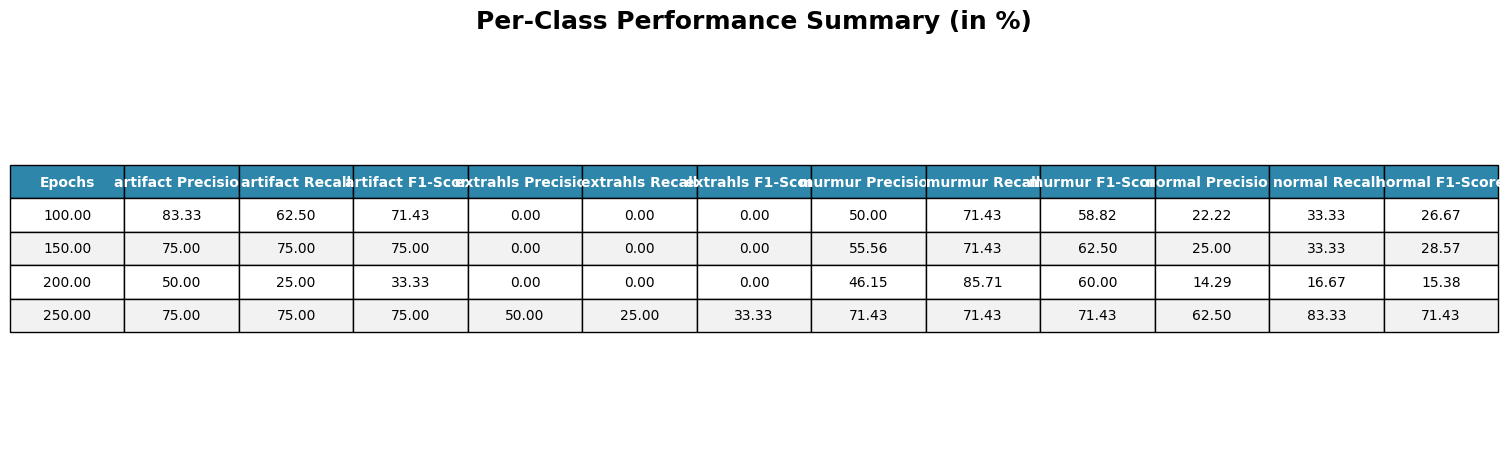


--- Generating Accuracy and Loss Curves ---


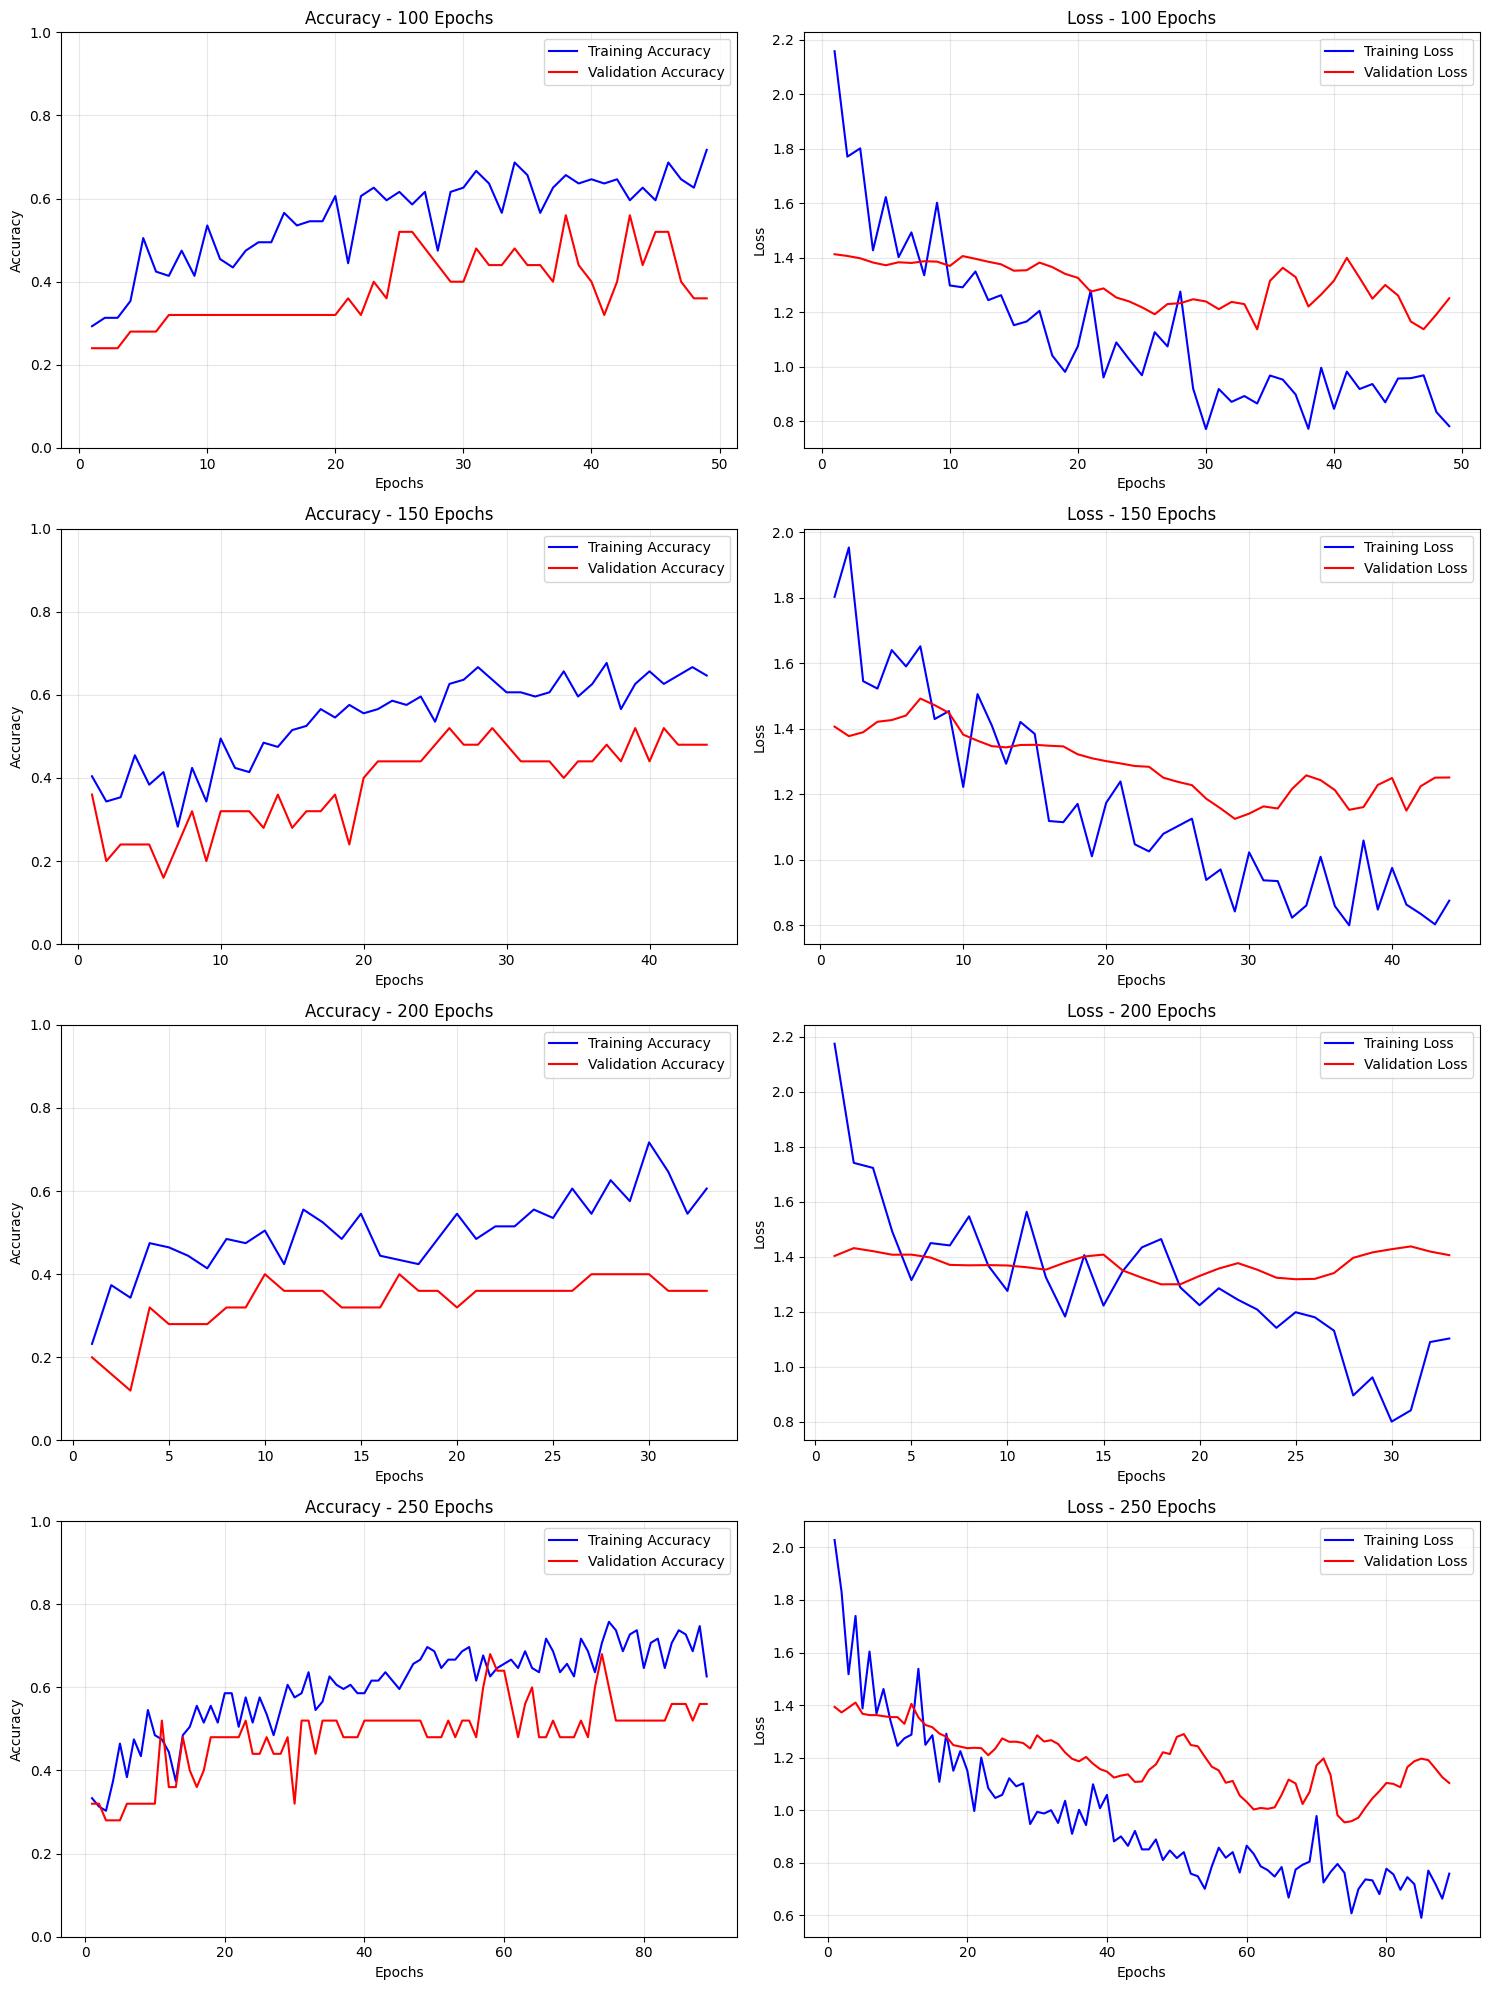


--- Generating Confusion Matrices ---


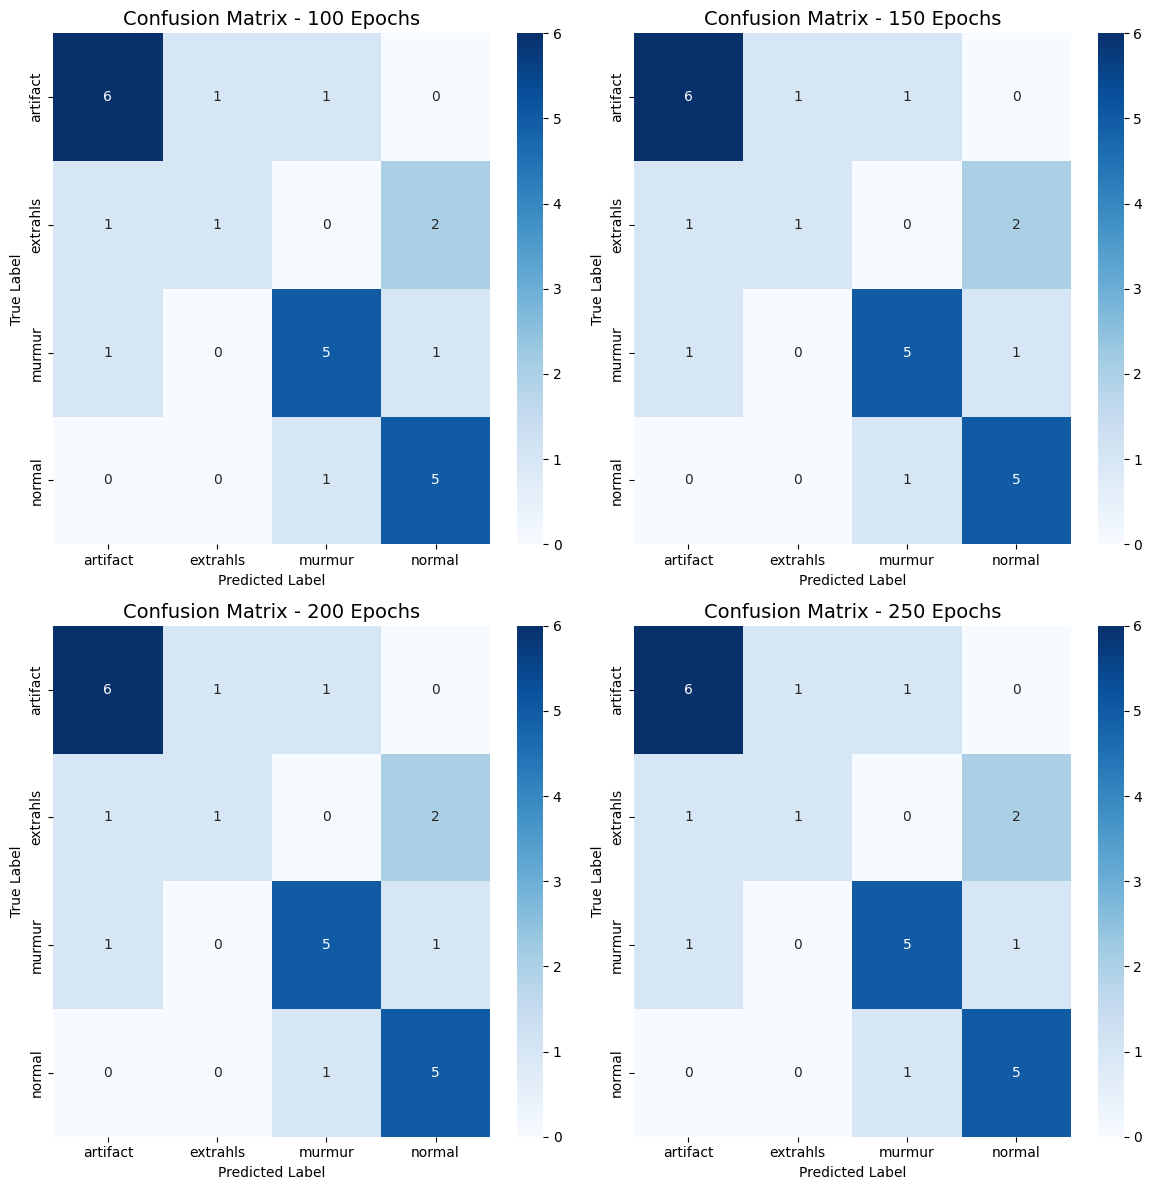

In [ ]:
# --- Advanced Hybrid CNN-Bi-LSTM Model for Heart Sound Classification on set_a ---

# Step 1: Install and Import Libraries
# !pip install librosa soundfile scikit-learn tensorflow seaborn
import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, BatchNormalization, Input, Reshape, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import random

# --- Step 2: Mount Google Drive ---
print("Mounting Google Drive...")
drive.mount('/content/drive')

# --- Step 3: Define Paths ---
INPUT_DIR_A_CSV = "/content/drive/MyDrive/Colab Notebooks/Heartbeat/set_a.csv"
INPUT_DIR_A_WAVE = "/content/drive/MyDrive/Colab Notebooks/Heartbeat/set_a"

# --- Step 4: Load and Clean the set_a Dataset ---
print("\nStep 4: Loading and cleaning the set_a dataset...")
try:
    df_a = pd.read_csv(INPUT_DIR_A_CSV)
    print(f"set_a loaded from CSV. Shape: {df_a.shape}")

    # Clean the dataset: Remove rows with missing labels and invalid file names
    df_a_clean = df_a.dropna(subset=['label'])
    df_a_clean = df_a_clean[df_a_clean['fname'].str.strip() != '']
    df_a_clean = df_a_clean[df_a_clean['label'] != '']

    print(f"set_a cleaned: {df_a_clean.shape[0]} usable samples")
    print("Label distribution:")
    print(df_a_clean['label'].value_counts())

except Exception as e:
    print(f"Error loading or cleaning set_a.csv: {e}")
    df_a_clean = pd.DataFrame()

# --- Step 5: Advanced Preprocessing with Data Augmentation ---
if not df_a_clean.empty:
    # Create label mapping
    unique_labels = sorted(df_a_clean['label'].unique())
    label_to_int = {label: i for i, label in enumerate(unique_labels)}
    num_classes = len(unique_labels)
    print(f"\nFound {num_classes} classes: {unique_labels}")

    # Parameters
    SAMPLE_RATE = 22050
    N_MELS = 128
    TARGET_WIDTH = 128
    TARGET_HEIGHT = 64  # For the CNN

    X = []
    y = []

    print("\nStep 5: Extracting Mel-spectrogram features with augmentation for Hybrid Model...")

    def augment_audio(audio):
        """Apply random augmentation to the audio signal."""
        aug_type = random.choice(['none', 'noise', 'stretch', 'shift'])
        if aug_type == 'noise':
            noise = np.random.randn(len(audio)) * 0.002
            return audio + noise
        elif aug_type == 'stretch':
            rate = random.uniform(0.95, 1.05)
            return librosa.effects.time_stretch(y=audio, rate=rate)
        elif aug_type == 'shift':
            n_steps = random.randint(-1, 1)
            return librosa.effects.pitch_shift(y=audio, sr=SAMPLE_RATE, n_steps=n_steps)
        else:
            return audio

    for _, row in df_a_clean.iterrows():
        file_name = row['fname']
        label = row['label']

        # Fix the file path
        if file_name.startswith('set_a/'):
            relative_file_name = file_name[len('set_a/'):]
        else:
            relative_file_name = file_name
        audio_path = os.path.join(INPUT_DIR_A_WAVE, relative_file_name)

        try:
            # Load the audio file
            audio, sample_rate = sf.read(audio_path)

            # Ensure the audio is mono
            if len(audio.shape) > 1:
                audio = np.mean(audio, axis=1)

            # Resample to a standard rate
            if sample_rate != SAMPLE_RATE:
                audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=SAMPLE_RATE)

            # Apply augmentation
            aug_audio = augment_audio(audio)

            # Extract Mel-spectrogram
            mel = librosa.feature.melspectrogram(y=aug_audio, sr=SAMPLE_RATE, n_mels=N_MELS, fmax=8000)
            log_mel = librosa.power_to_db(mel, ref=np.max)

            # Pad or truncate to target dimensions
            if log_mel.shape[1] < TARGET_WIDTH:
                log_mel = np.pad(log_mel, ((0,0), (0, TARGET_WIDTH-log_mel.shape[1])), mode='constant')
            else:
                log_mel = log_mel[:, :TARGET_WIDTH]

            if log_mel.shape[0] > TARGET_HEIGHT:
                log_mel = log_mel[:TARGET_HEIGHT, :]
            elif log_mel.shape[0] < TARGET_HEIGHT:
                pad_width = TARGET_HEIGHT - log_mel.shape[0]
                log_mel = np.pad(log_mel, ((0, pad_width), (0, 0)), mode='constant')

            # Add channel dimension for CNN
            log_mel = np.expand_dims(log_mel, axis=-1) # Shape: (64, 128, 1)
            X.append(log_mel)
            y.append(label_to_int[label])

        except Exception as e:
            print(f"Error processing {file_name}: {e}")

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    if len(X) > 0:
        print(f"Feature extraction complete. Final data shape: {X.shape}")

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
    else:
        print("ERROR: No valid audio files were processed.")
        X_train, X_test, y_train, y_test = None, None, None, None
else:
    print("No valid data in set_a to process.")
    X_train, X_test, y_train, y_test = None, None, None, None

# --- Step 6: Build, Train, and Evaluate the Advanced Hybrid Model ---
if X_train is not None:
    # Fixed parameters
    BATCH_SIZE = 16
    EPOCHS_LIST = [100, 150, 200, 250]
    results = []

    print("\nStep 6: Building and training the Advanced Hybrid CNN-Bi-LSTM model for different epochs...")

    def create_advanced_hybrid_model():
        model = Sequential([
            Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),

            # CNN layers for spatial feature extraction
            Conv2D(32, (3,3), activation='relu', padding='same'), BatchNormalization(), Dropout(0.2),
            Conv2D(32, (3,3), activation='relu', padding='same'), MaxPooling2D((2,2)),
            Conv2D(64, (3,3), activation='relu', padding='same'), BatchNormalization(), Dropout(0.3),
            Conv2D(64, (3,3), activation='relu', padding='same'), MaxPooling2D((2,2)),
            Conv2D(128, (3,3), activation='relu', padding='same'), BatchNormalization(), Dropout(0.4),
            Conv2D(128, (3,3), activation='relu', padding='same'), MaxPooling2D((2,2)),

            # Reshape for Bi-LSTM: (timesteps, features)
            # CNN output shape: (8, 16, 128) -> Reshape to (16, 8*128) = (16, 1024)
            Reshape((X_train.shape[2] // 8, (X_train.shape[1] // 8) * 128)),

            # Bi-LSTM layers for temporal feature extraction
            Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)),
            Bidirectional(LSTM(32, dropout=0.3, recurrent_dropout=0.3)),

            # Dense layers for classification
            Dense(128, activation='relu'), BatchNormalization(), Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    # Train a separate model for each epoch value
    for epochs in EPOCHS_LIST:
        print(f"\n--- Training Advanced Hybrid CNN-Bi-LSTM Model with {epochs} Epochs ---")
        model = create_advanced_hybrid_model()
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)

        # Train the model
        history = model.fit(
            X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        y_pred = model.predict(X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate metrics
        precision = precision_score(y_test, y_pred_classes, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred_classes, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred_classes, average='weighted', zero_division=0)
        class_report = classification_report(y_test, y_pred_classes, target_names=unique_labels,
                                             output_dict=True, zero_division=0)

        # Store results
        result = {
            'Epochs': epochs,
            'Accuracy': test_accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'History': history,
            'Classification_Report': class_report
        }
        results.append(result)

        # Print results for this run
        print(f"Results for {epochs} epochs:")
        print(f"  Test Accuracy: {test_accuracy*100:.2f}%")
        print(f"  Precision: {precision*100:.2f}%")
        print(f"  Recall: {recall*100:.2f}%")
        print(f"  F1-Score: {f1*100:.2f}%")

    # --- Step 7: Final Summary and Comprehensive Visualization ---
    print("\n=== FINAL RESULTS SUMMARY (Advanced Hybrid CNN-Bi-LSTM on set_a) ===")
    for result in results:
        print(f"Epochs: {result['Epochs']:3d} | "
              f"Acc: {result['Accuracy']*100:6.2f}% | "
              f"Precision: {result['Precision']*100:6.2f}% | "
              f"Recall: {result['Recall']*100:6.2f}% | "
              f"F1: {result['F1-Score']*100:6.2f}%")

    # --- 1. Create a Detailed Classification Report Table (Graphical Box) ---

# --- 1. Create a Detailed Classification Report Table (Graphical Box) ---
      print("\n--- Generating Classification Report Table ---")

      # Prepare data for the table
      summary_data = []
      for result in results:
          row = {'Epochs': result['Epochs']}
          class_report = result['Classification_Report']
          for label in unique_labels:
              if label in class_report:
                  # Truncate the label name to avoid long column headers
                  short_label = label[:15]  # Limit to first 10 characters
                  row[f'{short_label} Precision'] = class_report[label]['precision'] * 100
                  row[f'{short_label} Recall'] = class_report[label]['recall'] * 100
                  row[f'{short_label} F1-Score'] = class_report[label]['f1-score'] * 100
              else:
                  row[f'{short_label} Precision'] = 0.0
                  row[f'{short_label} Recall'] = 0.0
                  row[f'{short_label} F1-Score'] = 0.0
          summary_data.append(row)

      # Define column labels with truncated names and spaces
      col_labels = ['Epochs'] + [f'{label[:15]} {metric}' for label in unique_labels for metric in ['Precision', 'Recall', 'F1-Score']]
      # Format the data for the table
      cell_data = [[f"{item:.2f}" for item in row.values()] for row in summary_data]

      # Create a figure for the summary table
      fig, ax = plt.subplots(figsize=(16, len(summary_data) * 1.0 + 1))
      ax.axis('tight')
      ax.axis('off')
      ax.set_title('Per-Class Performance Summary (in %)', fontsize=18, pad=20, fontweight='bold')

      # Create the table
      table = ax.table(cellText=cell_data,
                      colLabels=col_labels,
                      cellLoc='center',
                      loc='center')

      # Style the table
      table.auto_set_font_size(False)
      table.set_fontsize(10)
      table.scale(1.6, 3)

      # Color the header and alternate rows
      header_color = '#2E86AB' # A professional blue
      even_row_color = '#F2F2F2'
      odd_row_color = 'white'

      for i in range(len(summary_data) + 1):
          for j in range(len(col_labels)):
              cell = table[(i, j)]
              if i == 0:
                  cell.set_facecolor(header_color)
                  cell.set_text_props(color='white', weight='bold')
              elif i % 2 == 0:
                  cell.set_facecolor(even_row_color)
              else:
                  cell.set_facecolor(odd_row_color)

      plt.show()


    # --- 2. Plot Accuracy and Loss Curves for All Epoch Values ---
    print("\n--- Generating Accuracy and Loss Curves ---")

    fig, axes = plt.subplots(len(results), 2, figsize=(15, 5 * len(results)))
    if len(results) == 1:
        axes = axes.reshape(1, -1)

    for idx, result in enumerate(results):
        history = result['History']
        epochs = range(1, len(history.history['loss']) + 1)

        # Plot Accuracy
        axes[idx, 0].plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
        axes[idx, 0].plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
        axes[idx, 0].set_title(f'Accuracy - {result["Epochs"]} Epochs')
        axes[idx, 0].set_xlabel('Epochs')
        axes[idx, 0].set_ylabel('Accuracy')
        axes[idx, 0].legend()
        axes[idx, 0].grid(True, alpha=0.3)
        axes[idx, 0].set_ylim(0, 1)

        # Plot Loss
        axes[idx, 1].plot(epochs, history.history['loss'], 'b-', label='Training Loss')
        axes[idx, 1].plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
        axes[idx, 1].set_title(f'Loss - {result["Epochs"]} Epochs')
        axes[idx, 1].set_xlabel('Epochs')
        axes[idx, 1].set_ylabel('Loss')
        axes[idx, 1].legend()
        axes[idx, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- 3. Create Confusion Matrices for Each Epoch Value ---
    print("\n--- Generating Confusion Matrices ---")

    n_results = len(results)
    cols = 2
    rows = (n_results + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6 * rows))
    if n_results == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, result in enumerate(results):
        # Get predictions from the model for this epoch run
        y_pred = model.predict(X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred_classes)

        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                    xticklabels=unique_labels, yticklabels=unique_labels)
        axes[idx].set_title(f'Confusion Matrix - {result["Epochs"]} Epochs', fontsize=14)
        axes[idx].set_xlabel('Predicted Label')
        axes[idx].set_ylabel('True Label')

    # Remove any unused subplots
    for idx in range(n_results, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

else:
    print("Model training skipped due to lack of data.")

# **CNN + GRU**

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Step 4: Loading and cleaning the set_a dataset...
set_a loaded from CSV. Shape: (176, 4)
set_a cleaned: 124 usable samples
Label distribution:
label
artifact    40
murmur      34
normal      31
extrahls    19
Name: count, dtype: int64

Found 4 classes: ['artifact', 'extrahls', 'murmur', 'normal']

Step 5: Extracting Mel-spectrogram features with augmentation for Hybrid Model...
Feature extraction complete. Final data shape: (124, 64, 128, 1)
Training set: (99, 64, 128, 1), Test set: (25, 64, 128, 1)

Step 6: Building and training the Advanced Hybrid CNN-GRU model for different epochs...

--- Training Advanced Hybrid CNN-GRU Model with 100 Epochs ---
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 303ms/step - accuracy: 0.2606 - loss: 2.0694 - val_accuracy: 0.2800 - val_loss: 1.4605 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━

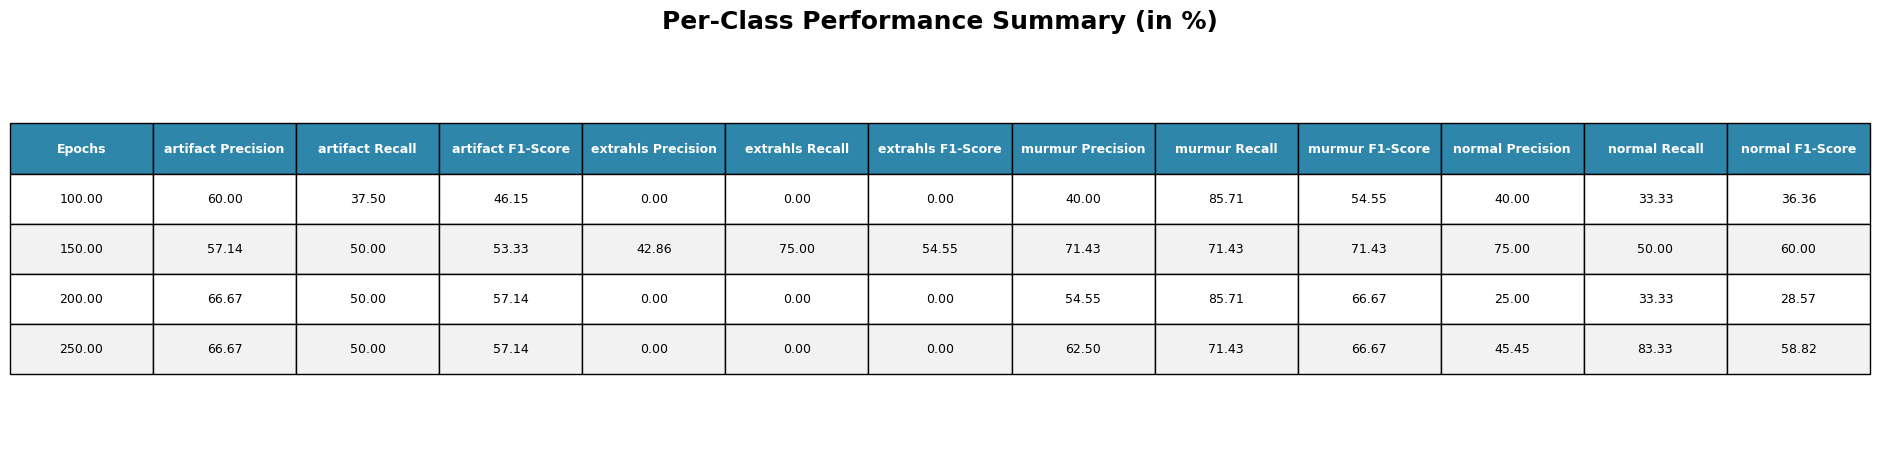


--- Generating Accuracy and Loss Curves ---


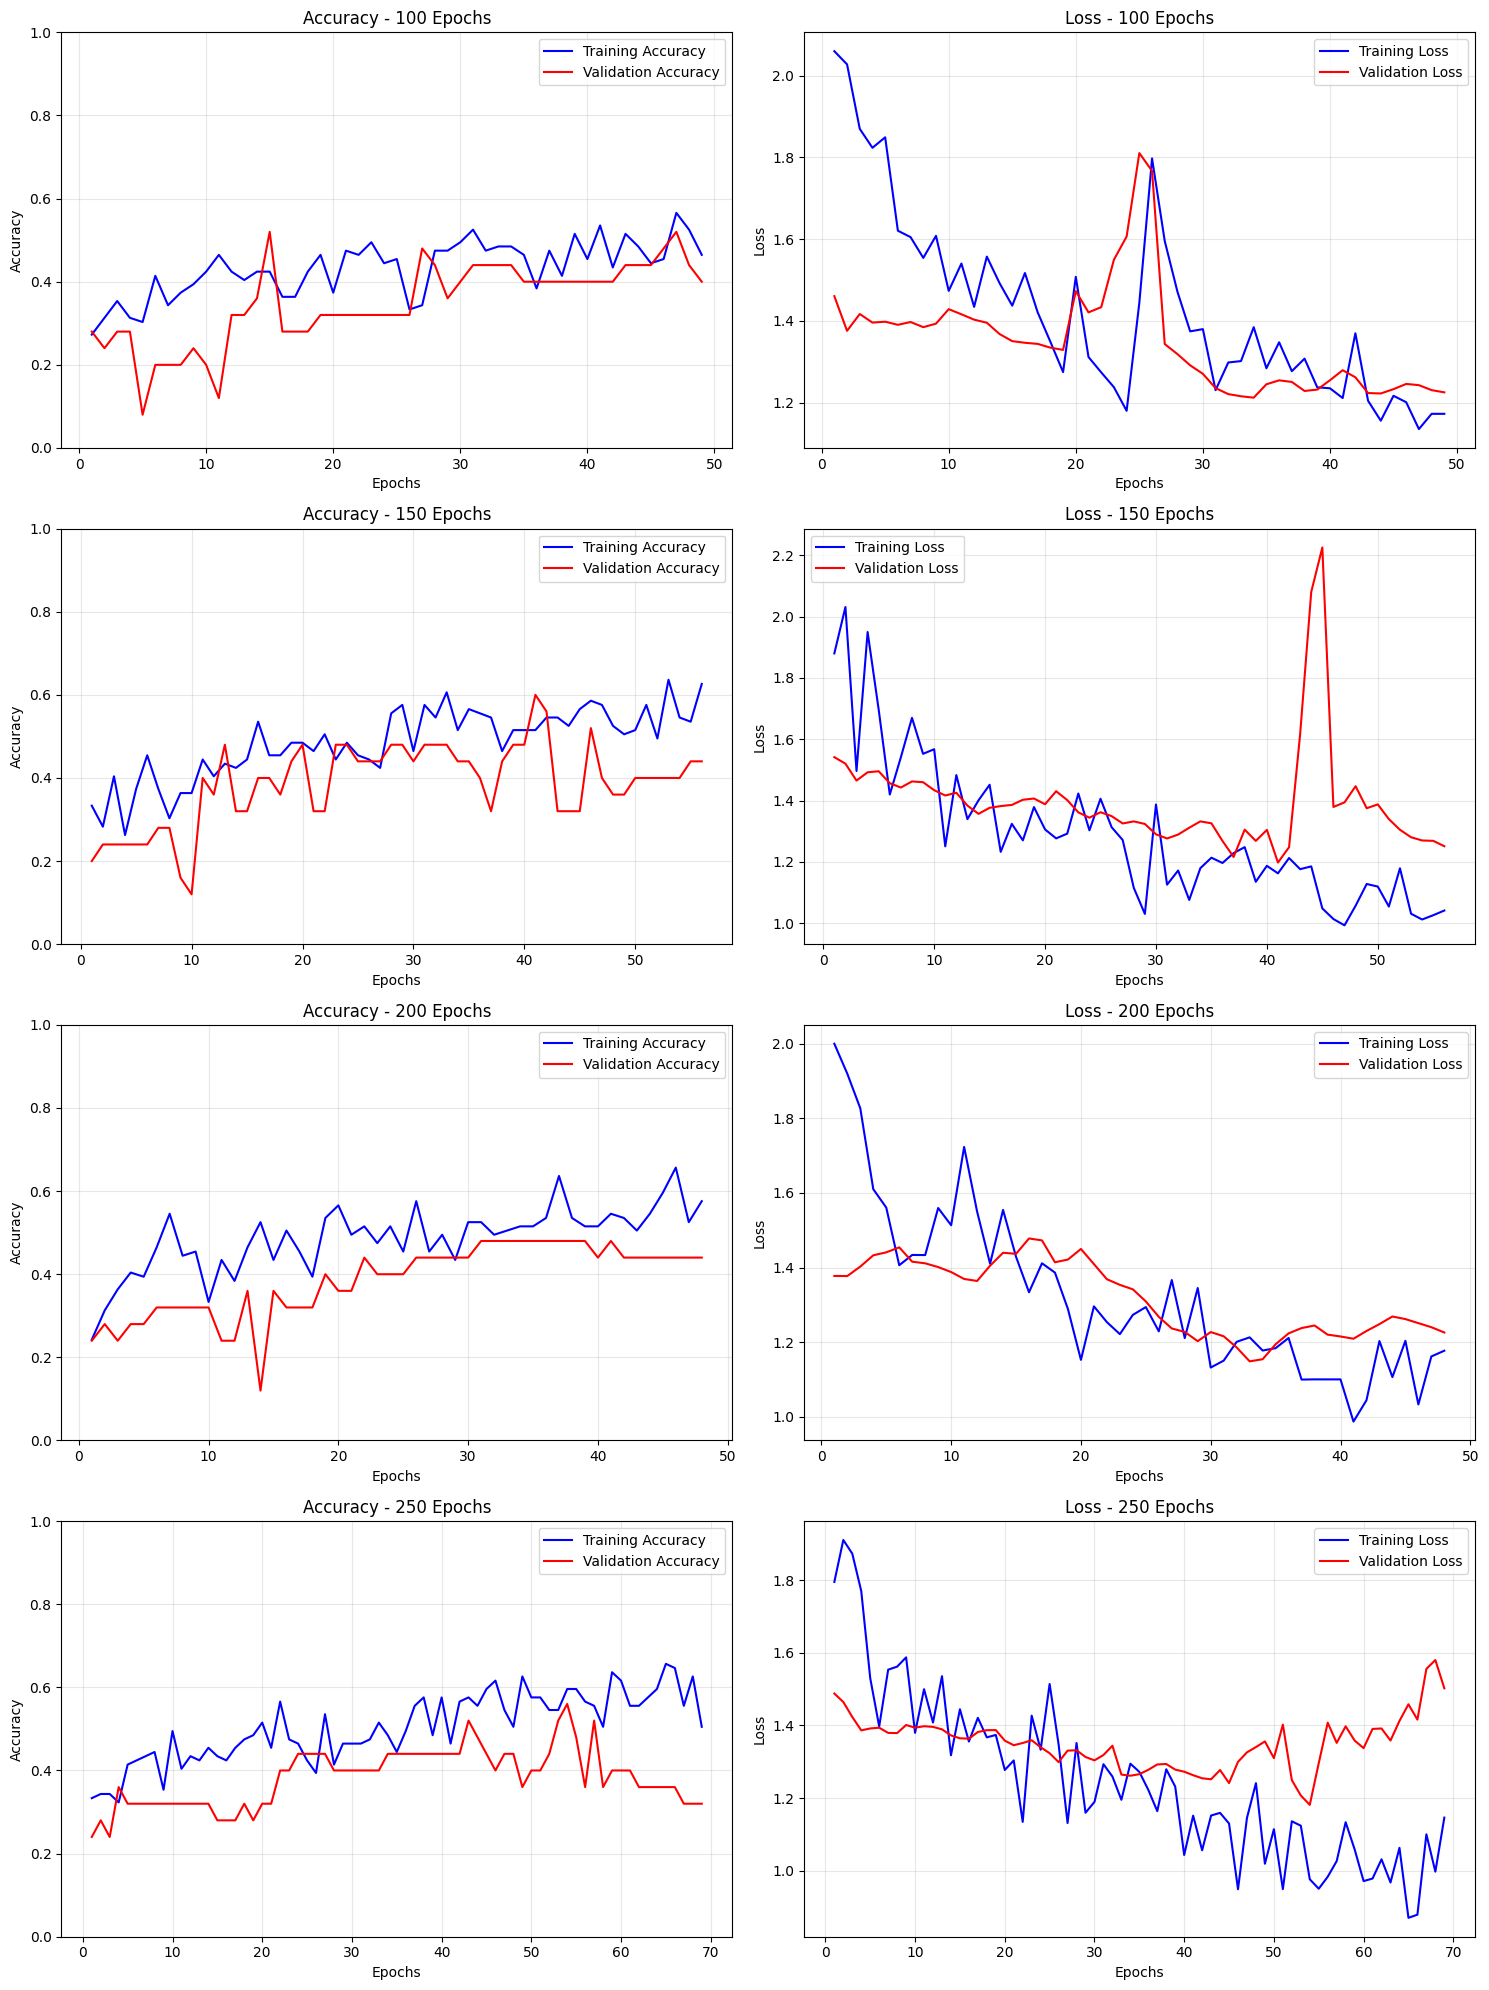


--- Generating Confusion Matrices ---


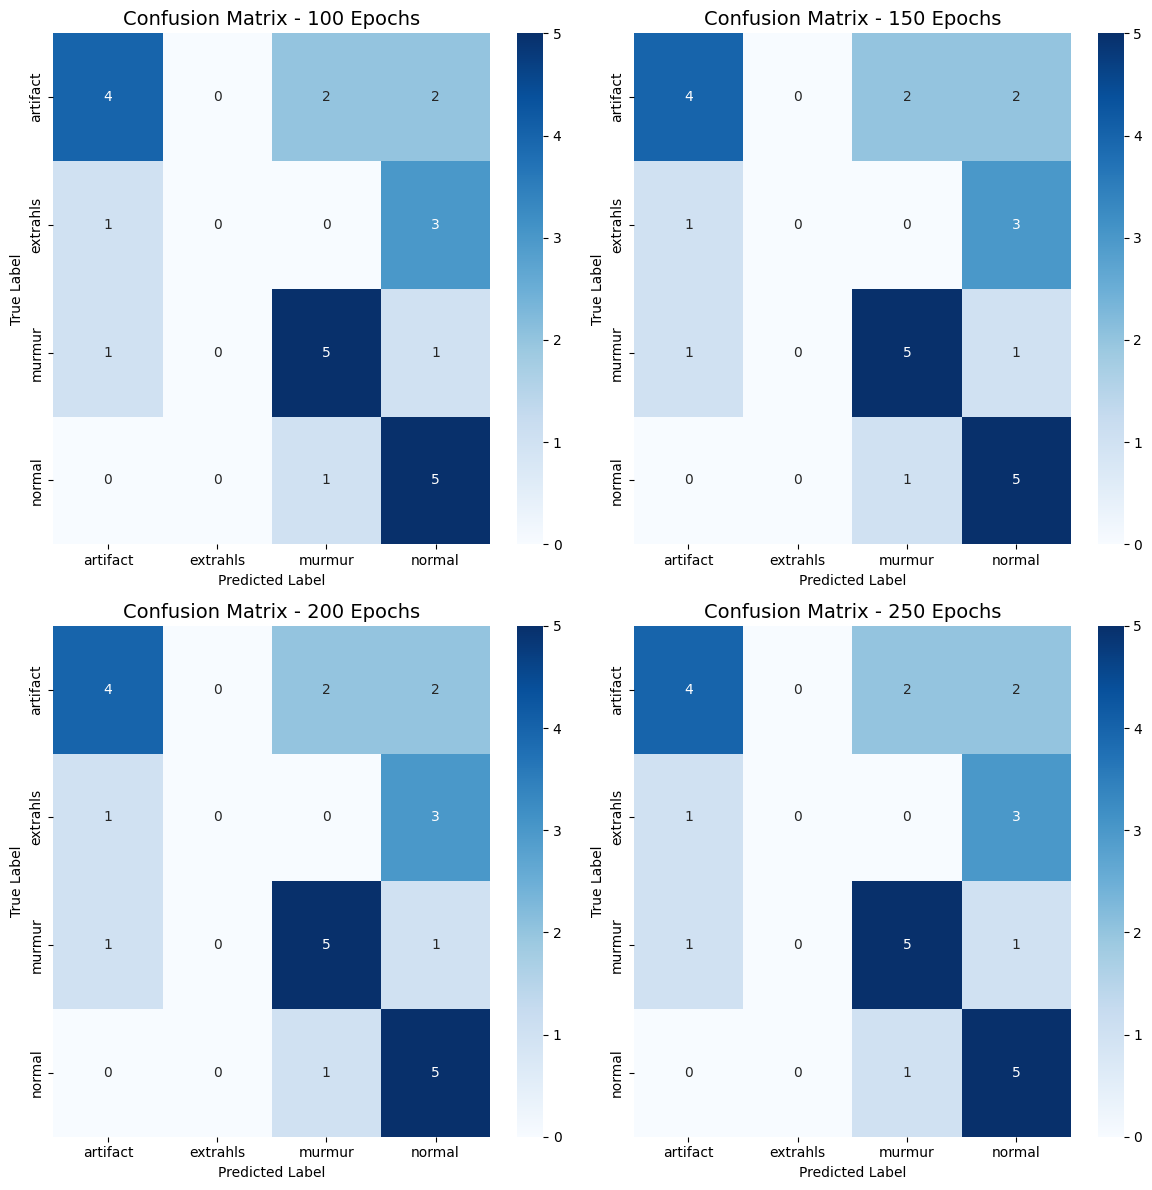

In [ ]:
# --- Advanced Hybrid CNN-GRU Model for Heart Sound Classification on set_a ---

# Step 1: Install and Import Libraries
# !pip install librosa soundfile scikit-learn tensorflow seaborn
import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GRU, Dense, Dropout, BatchNormalization, Input, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import random

# --- Step 2: Mount Google Drive ---
print("Mounting Google Drive...")
drive.mount('/content/drive')

# --- Step 3: Define Paths ---
INPUT_DIR_A_CSV = "/content/drive/MyDrive/Colab Notebooks/Heartbeat/set_a.csv"
INPUT_DIR_A_WAVE = "/content/drive/MyDrive/Colab Notebooks/Heartbeat/set_a"

# --- Step 4: Load and Clean the set_a Dataset ---
print("\nStep 4: Loading and cleaning the set_a dataset...")
try:
    df_a = pd.read_csv(INPUT_DIR_A_CSV)
    print(f"set_a loaded from CSV. Shape: {df_a.shape}")

    # Clean the dataset: Remove rows with missing labels and invalid file names
    df_a_clean = df_a.dropna(subset=['label'])
    df_a_clean = df_a_clean[df_a_clean['fname'].str.strip() != '']
    df_a_clean = df_a_clean[df_a_clean['label'] != '']

    print(f"set_a cleaned: {df_a_clean.shape[0]} usable samples")
    print("Label distribution:")
    print(df_a_clean['label'].value_counts())

except Exception as e:
    print(f"Error loading or cleaning set_a.csv: {e}")
    df_a_clean = pd.DataFrame()

# --- Step 5: Advanced Preprocessing with Data Augmentation ---
if not df_a_clean.empty:
    # Create label mapping
    unique_labels = sorted(df_a_clean['label'].unique())
    label_to_int = {label: i for i, label in enumerate(unique_labels)}
    num_classes = len(unique_labels)
    print(f"\nFound {num_classes} classes: {unique_labels}")

    # Parameters
    SAMPLE_RATE = 22050
    N_MELS = 128
    TARGET_WIDTH = 128
    TARGET_HEIGHT = 64  # For the CNN

    X = []
    y = []

    print("\nStep 5: Extracting Mel-spectrogram features with augmentation for Hybrid Model...")

    def augment_audio(audio):
        """Apply random augmentation to the audio signal."""
        aug_type = random.choice(['none', 'noise', 'stretch', 'shift'])
        if aug_type == 'noise':
            noise = np.random.randn(len(audio)) * 0.002
            return audio + noise
        elif aug_type == 'stretch':
            rate = random.uniform(0.95, 1.05)
            return librosa.effects.time_stretch(y=audio, rate=rate)
        elif aug_type == 'shift':
            n_steps = random.randint(-1, 1)
            return librosa.effects.pitch_shift(y=audio, sr=SAMPLE_RATE, n_steps=n_steps)
        else:
            return audio

    for _, row in df_a_clean.iterrows():
        file_name = row['fname']
        label = row['label']

        # Fix the file path
        if file_name.startswith('set_a/'):
            relative_file_name = file_name[len('set_a/'):]
        else:
            relative_file_name = file_name
        audio_path = os.path.join(INPUT_DIR_A_WAVE, relative_file_name)

        try:
            # Load the audio file
            audio, sample_rate = sf.read(audio_path)

            # Ensure the audio is mono
            if len(audio.shape) > 1:
                audio = np.mean(audio, axis=1)

            # Resample to a standard rate
            if sample_rate != SAMPLE_RATE:
                audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=SAMPLE_RATE)

            # Apply augmentation
            aug_audio = augment_audio(audio)

            # Extract Mel-spectrogram
            mel = librosa.feature.melspectrogram(y=aug_audio, sr=SAMPLE_RATE, n_mels=N_MELS, fmax=8000)
            log_mel = librosa.power_to_db(mel, ref=np.max)

            # Pad or truncate to target dimensions
            if log_mel.shape[1] < TARGET_WIDTH:
                log_mel = np.pad(log_mel, ((0,0), (0, TARGET_WIDTH-log_mel.shape[1])), mode='constant')
            else:
                log_mel = log_mel[:, :TARGET_WIDTH]

            if log_mel.shape[0] > TARGET_HEIGHT:
                log_mel = log_mel[:TARGET_HEIGHT, :]
            elif log_mel.shape[0] < TARGET_HEIGHT:
                pad_width = TARGET_HEIGHT - log_mel.shape[0]
                log_mel = np.pad(log_mel, ((0, pad_width), (0, 0)), mode='constant')

            # Add channel dimension for CNN
            log_mel = np.expand_dims(log_mel, axis=-1) # Shape: (64, 128, 1)
            X.append(log_mel)
            y.append(label_to_int[label])

        except Exception as e:
            print(f"Error processing {file_name}: {e}")

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    if len(X) > 0:
        print(f"Feature extraction complete. Final data shape: {X.shape}")

        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
    else:
        print("ERROR: No valid audio files were processed.")
        X_train, X_test, y_train, y_test = None, None, None, None
else:
    print("No valid data in set_a to process.")
    X_train, X_test, y_train, y_test = None, None, None, None

# --- Step 6: Build, Train, and Evaluate the Advanced Hybrid Model ---
if X_train is not None:
    # Fixed parameters
    BATCH_SIZE = 16
    EPOCHS_LIST = [100, 150, 200, 250]
    results = []

    print("\nStep 6: Building and training the Advanced Hybrid CNN-GRU model for different epochs...")

    def create_advanced_hybrid_model():
        model = Sequential([
            Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),

            # CNN layers for spatial feature extraction
            Conv2D(32, (3,3), activation='relu', padding='same'), BatchNormalization(), Dropout(0.2),
            Conv2D(32, (3,3), activation='relu', padding='same'), MaxPooling2D((2,2)),
            Conv2D(64, (3,3), activation='relu', padding='same'), BatchNormalization(), Dropout(0.3),
            Conv2D(64, (3,3), activation='relu', padding='same'), MaxPooling2D((2,2)),
            Conv2D(128, (3,3), activation='relu', padding='same'), BatchNormalization(), Dropout(0.4),
            Conv2D(128, (3,3), activation='relu', padding='same'), MaxPooling2D((2,2)),

            # Reshape for GRU: (timesteps, features)
            # CNN output shape: (8, 16, 128) -> Reshape to (16, 8*128) = (16, 1024)
            Reshape((X_train.shape[2] // 8, (X_train.shape[1] // 8) * 128)),

            # GRU layers for temporal feature extraction
            GRU(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True),
            GRU(32, dropout=0.3, recurrent_dropout=0.3),

            # Dense layers for classification
            Dense(128, activation='relu'), BatchNormalization(), Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])
        model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    # Train a separate model for each epoch value
    for epochs in EPOCHS_LIST:
        print(f"\n--- Training Advanced Hybrid CNN-GRU Model with {epochs} Epochs ---")
        model = create_advanced_hybrid_model()
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)

        # Train the model
        history = model.fit(
            X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        y_pred = model.predict(X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate metrics
        precision = precision_score(y_test, y_pred_classes, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred_classes, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred_classes, average='weighted', zero_division=0)
        class_report = classification_report(y_test, y_pred_classes, target_names=unique_labels,
                                             output_dict=True, zero_division=0)

        # Store results
        result = {
            'Epochs': epochs,
            'Accuracy': test_accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'History': history,
            'Classification_Report': class_report
        }
        results.append(result)

        # Print results for this run
        print(f"Results for {epochs} epochs:")
        print(f"  Test Accuracy: {test_accuracy*100:.2f}%")
        print(f"  Precision: {precision*100:.2f}%")
        print(f"  Recall: {recall*100:.2f}%")
        print(f"  F1-Score: {f1*100:.2f}%")

    # --- Step 7: Final Summary and Comprehensive Visualization ---
    print("\n=== FINAL RESULTS SUMMARY (Advanced Hybrid CNN-GRU on set_a) ===")
    for result in results:
        print(f"Epochs: {result['Epochs']:3d} | "
              f"Acc: {result['Accuracy']*100:6.2f}% | "
              f"Precision: {result['Precision']*100:6.2f}% | "
              f"Recall: {result['Recall']*100:6.2f}% | "
              f"F1: {result['F1-Score']*100:6.2f}%")

        # --- 1. Create a Detailed Classification Report Table (Graphical Box) ---
    print("\n--- Generating Classification Report Table ---")

    # Prepare data for the table
    summary_data = []
    for result in results:
        row = {'Epochs': result['Epochs']}
        class_report = result['Classification_Report']
        for label in unique_labels:
            if label in class_report:
                # Truncate the label name to avoid long column headers
                short_label = label[:15]  # Limit to first 10 characters
                row[f'{short_label} Precision'] = class_report[label]['precision'] * 100
                row[f'{short_label} Recall'] = class_report[label]['recall'] * 100
                row[f'{short_label} F1-Score'] = class_report[label]['f1-score'] * 100
            else:
                row[f'{short_label} Precision'] = 0.0
                row[f'{short_label} Recall'] = 0.0
                row[f'{short_label} F1-Score'] = 0.0
        summary_data.append(row)

    # Define column labels with truncated names and spaces
    col_labels = ['Epochs'] + [f'{label[:15]} {metric}' for label in unique_labels for metric in ['Precision', 'Recall', 'F1-Score']]
    # Format the data for the table
    cell_data = [[f"{item:.2f}" for item in row.values()] for row in summary_data]

    # Create a figure for the summary table
    fig, ax = plt.subplots(figsize=(16, len(summary_data) * 1.0 + 1))
    ax.axis('tight')
    ax.axis('off')
    ax.set_title('Per-Class Performance Summary (in %)', fontsize=18, pad=20, fontweight='bold')

    # Create the table
    table = ax.table(cellText=cell_data,
                    colLabels=col_labels,
                    cellLoc='center',
                    loc='center')

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.5, 3)

    # Color the header and alternate rows
    header_color = '#2E86AB' # A professional blue
    even_row_color = '#F2F2F2'
    odd_row_color = 'white'

    for i in range(len(summary_data) + 1):
        for j in range(len(col_labels)):
            cell = table[(i, j)]
            if i == 0:
                cell.set_facecolor(header_color)
                cell.set_text_props(color='white', weight='bold')
            elif i % 2 == 0:
                cell.set_facecolor(even_row_color)
            else:
                cell.set_facecolor(odd_row_color)

    plt.show()

    # --- 2. Plot Accuracy and Loss Curves for All Epoch Values ---
    print("\n--- Generating Accuracy and Loss Curves ---")

    fig, axes = plt.subplots(len(results), 2, figsize=(15, 5 * len(results)))
    if len(results) == 1:
        axes = axes.reshape(1, -1)

    for idx, result in enumerate(results):
        history = result['History']
        epochs = range(1, len(history.history['loss']) + 1)

        # Plot Accuracy
        axes[idx, 0].plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')
        axes[idx, 0].plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy')
        axes[idx, 0].set_title(f'Accuracy - {result["Epochs"]} Epochs')
        axes[idx, 0].set_xlabel('Epochs')
        axes[idx, 0].set_ylabel('Accuracy')
        axes[idx, 0].legend()
        axes[idx, 0].grid(True, alpha=0.3)
        axes[idx, 0].set_ylim(0, 1)

        # Plot Loss
        axes[idx, 1].plot(epochs, history.history['loss'], 'b-', label='Training Loss')
        axes[idx, 1].plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
        axes[idx, 1].set_title(f'Loss - {result["Epochs"]} Epochs')
        axes[idx, 1].set_xlabel('Epochs')
        axes[idx, 1].set_ylabel('Loss')
        axes[idx, 1].legend()
        axes[idx, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- 3. Create Confusion Matrices for Each Epoch Value ---
    print("\n--- Generating Confusion Matrices ---")

    n_results = len(results)
    cols = 2
    rows = (n_results + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6 * rows))
    if n_results == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, result in enumerate(results):
        # Get predictions from the model for this epoch run
        y_pred = model.predict(X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred_classes)

        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                    xticklabels=unique_labels, yticklabels=unique_labels)
        axes[idx].set_title(f'Confusion Matrix - {result["Epochs"]} Epochs', fontsize=14)
        axes[idx].set_xlabel('Predicted Label')
        axes[idx].set_ylabel('True Label')

    # Remove any unused subplots
    for idx in range(n_results, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

else:
    print("Model training skipped due to lack of data.")